In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.rcParams.update({'font.size': 20})

Plot bozorth3 values for impostors and genuines on one graph. (0.25 pts)

In [49]:
scores_df = pd.read_csv('scores.csv')

def is_genuine(row):
    return row['File1'].split('_')[0] == row['File2'].split('_')[0]

# Filter out rows where File1 and File2 are the same
filtered_scores_df = scores_df[scores_df['File1'] != scores_df['File2']]

filtered_scores_df['Comparison_Type'] = filtered_scores_df.apply(is_genuine, axis=1)

genuine_scores = filtered_scores_df[filtered_scores_df['Comparison_Type'] == True]['Score']
impostor_scores = filtered_scores_df[filtered_scores_df['Comparison_Type'] == False]['Score']

C:\Users\grilj\AppData\Local\Temp\ipykernel_14840\2152404567.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_scores_df['Comparison_Type'] = filtered_scores_df.apply(is_genuine, axis=1)


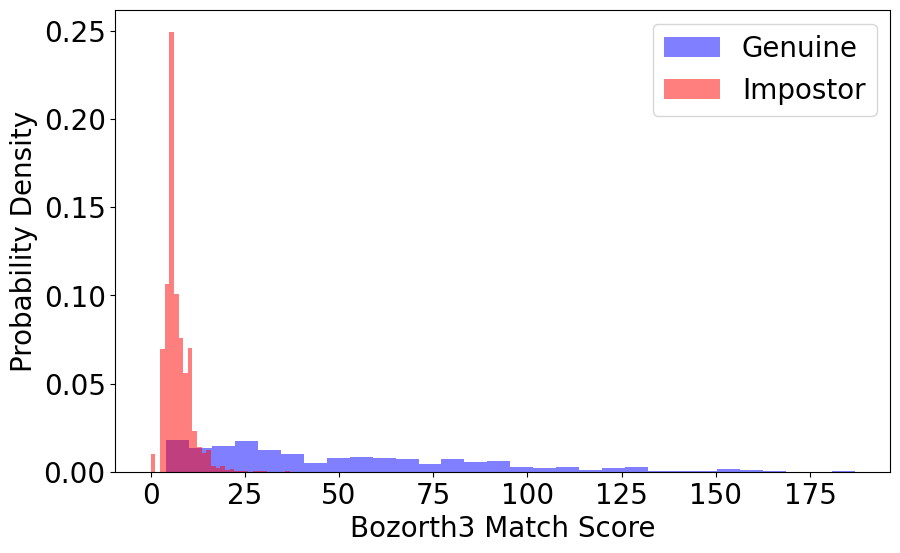

In [50]:
# Plotting the data
plt.figure(figsize=(10, 6))
plt.hist(genuine_scores, bins=30, alpha=0.5, label='Genuine', color='blue', density=True)
plt.hist(impostor_scores, bins=30, alpha=0.5, label='Impostor', color='red', density=True)
#plt.title('Bozorth3 Match Scores for Genuine and Impostor Comparisons')
plt.xlabel('Bozorth3 Match Score')
plt.ylabel('Probability Density')
plt.legend()
plt.savefig('match_scores_plot.pdf', format='pdf', bbox_inches='tight')
plt.show()

Plot the similarity matrix of all the comparisons (0.25 pts)

In [51]:
# Get unique files
unique_files = sorted(set(scores_df['File1']).union(set(scores_df['File2'])))
file_to_idx = {file: idx for idx, file in enumerate(unique_files)}

# Create an empty similarity matrix
N = len(unique_files)
similarity_matrix = np.zeros((N, N))

# Fill the similarity matrix with scores
for _, row in scores_df.iterrows():
    idx1 = file_to_idx[row['File1']]
    idx2 = file_to_idx[row['File2']]
    similarity_matrix[idx1, idx2] = row['Score']
    similarity_matrix[idx2, idx1] = row['Score']  # Symmetric


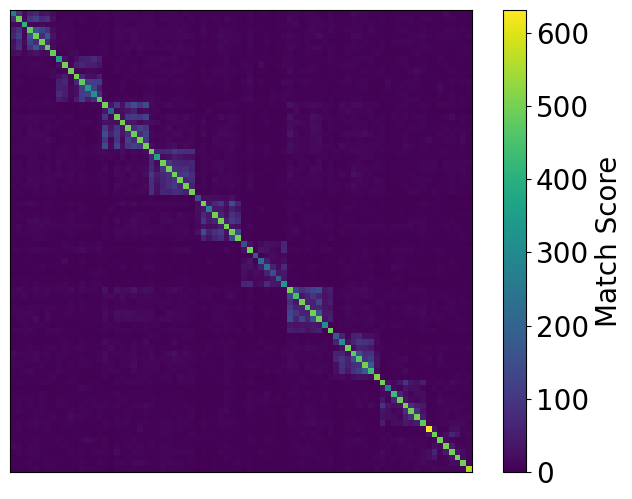

In [52]:
# Plot the similarity matrix as a heatmap
plt.figure(figsize=(8, 6))
plt.imshow(similarity_matrix, interpolation='nearest')
plt.colorbar(label='Match Score')
#plt.title('Bozorth3 Similarity Matrix')
#plt.xlabel('Fingerprint Image Index')
#plt.ylabel('Fingerprint Image Index')

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    labelbottom=False) # labels along the bottom edge are off

plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    labelleft=False) # labels along the bottom edge are off

# plt.xticks(ticks=np.arange(N), labels=unique_files, rotation=90)
# plt.yticks(ticks=np.arange(N), labels=unique_files)
plt.savefig('similarity_matrix_plot.pdf', format='pdf', bbox_inches='tight')
plt.show()

Using nfiq (nfiq img.png), which gives you an estimate of fingerprint quality (1 is best, 5 is worst), plot the quality values of the fingerprints. (0.25 pts)

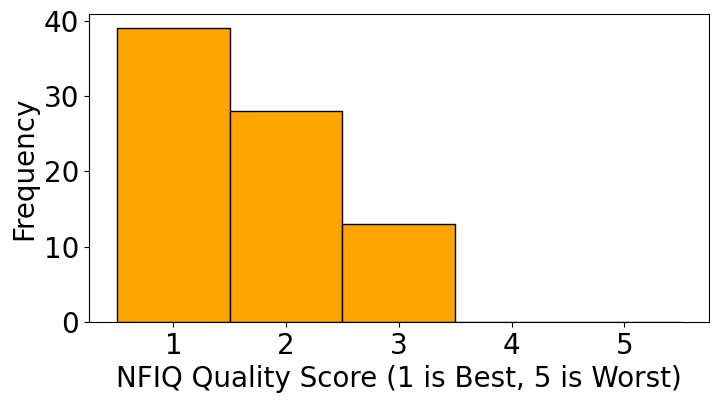

In [53]:
df = pd.read_csv('nfiq_scores.csv')

# # Plot a bar chart of NFIQ scores
# plt.figure(figsize=(10, 6))
# plt.bar(df['File'], df['NFIQ_Score'], color='teal')
# plt.title('NFIQ Fingerprint Quality Scores')
# plt.xlabel('Fingerprint Image')
# plt.ylabel('NFIQ Quality Score (1 is Best, 5 is Worst)')
# plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
# plt.show()

# Plot a histogram of NFIQ scores to show the distribution
plt.figure(figsize=(8, 4))
plt.hist(df['NFIQ_Score'], bins=range(1, 7), edgecolor='black', color='orange', align='left')
#plt.title('Distribution of NFIQ Fingerprint Quality Scores')
plt.xlabel('NFIQ Quality Score (1 is Best, 5 is Worst)')
plt.ylabel('Frequency')
plt.xticks(ticks=range(1, 6))
plt.savefig('nfiq_scores_plot.pdf', format='pdf', bbox_inches='tight')
plt.show()


Determine the best threshold for bozorth3 outputs (to distinguish same or different subjects) as accurately as possible.

EER Threshold: 12.747474747474747
EER: 0.09714781746031746


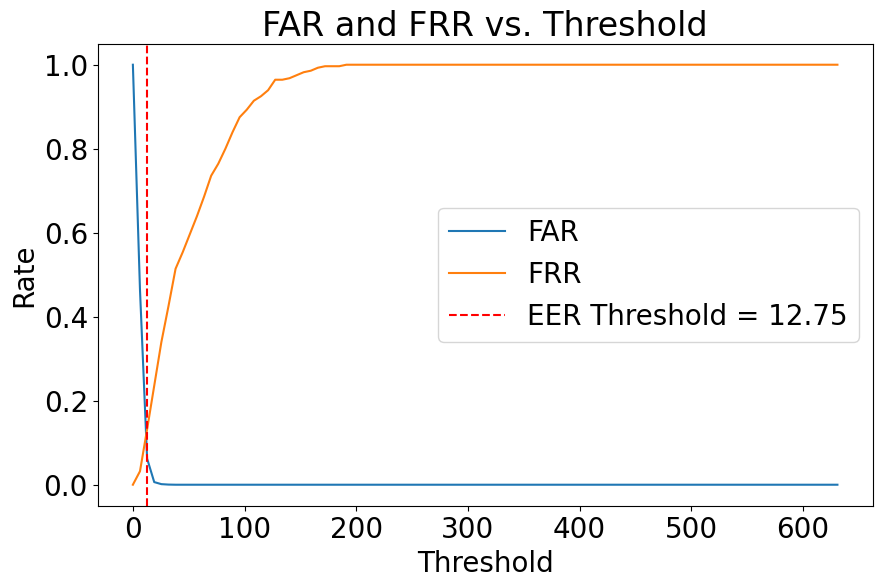

In [54]:
# Function to calculate False Acceptance Rate (FAR) and False Rejection Rate (FRR) for a given threshold
def calculate_far_frr(threshold, genuine_scores, impostor_scores):
    # FAR: Impostor scores above the threshold / total impostor scores
    far = np.sum(impostor_scores >= threshold) / len(impostor_scores)
    
    # FRR: Genuine scores below the threshold / total genuine scores
    frr = np.sum(genuine_scores < threshold) / len(genuine_scores)
    
    return far, frr

# Calculate FAR and FRR for a range of thresholds
thresholds = np.linspace(min(scores_df['Score']), max(scores_df['Score']), 100)
far_values = []
frr_values = []

for threshold in thresholds:
    far, frr = calculate_far_frr(threshold, genuine_scores, impostor_scores)
    far_values.append(far)
    frr_values.append(frr)

# Find the EER (Equal Error Rate) - threshold where FAR and FRR are closest
eer_index = np.argmin(np.abs(np.array(far_values) - np.array(frr_values)))
eer_threshold = thresholds[eer_index]
eer = (far_values[eer_index] + frr_values[eer_index]) / 2

print(f"EER Threshold: {eer_threshold}")
print(f"EER: {eer}")

plt.figure(figsize=(10, 6))
plt.plot(thresholds, far_values, label='FAR')
plt.plot(thresholds, frr_values, label='FRR')
plt.axvline(eer_threshold, color='red', linestyle='--', label=f'EER Threshold = {eer_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Rate')
plt.title('FAR and FRR vs. Threshold')
plt.legend()
plt.show()

In [55]:

# Remove redundant comparisons (e.g., keep only A vs B, not B vs A)
filtered_scores_df = filtered_scores_df[
    filtered_scores_df.apply(lambda row: row['File1'] < row['File2'], axis=1)
]

# Perform classification based on the threshold
filtered_scores_df['Predicted_Type'] = filtered_scores_df['Score'] >= eer_threshold

# Compare predicted types with actual types to determine correct classifications
filtered_scores_df['Correct'] = filtered_scores_df['Comparison_Type'] == filtered_scores_df['Predicted_Type']

# Calculate classification accuracy
accuracy = filtered_scores_df['Correct'].mean()
print(f"Classification Accuracy: {accuracy:.2f}")


Classification Accuracy: 0.93


Modify the classification so that you first classify each fingerprint by its type (A = Arch, L = Left Loop, R = Right Loop, S = Scar, T = Tented Arch, W = Whorl), and then only match within this subgroup. To do this, call pcasys pcasys.prs. 

In [56]:
# Remove comparisons between different types of fingerprints
fingerprints_types = pd.read_csv('filtered_pcasys_out.csv')
# filtered_scores_types_df = pd.DataFrame(columns=filtered_scores_df.columns)
# for index, comparison in filtered_scores_df.iterrows():
#     type1 = fingerprints_types[fingerprints_types["File"] == comparison["File1"]]["hyp"].values[0]
#     type2 = fingerprints_types[fingerprints_types["File"] == comparison["File2"]]["hyp"].values[0]
#     if type1 == type2:
#         filtered_scores_types_df = pd.concat([filtered_scores_types_df, pd.DataFrame([comparison])], ignore_index=True)

# Merge the fingerprints_types DataFrame with filtered_scores_df on both File1 and File2
merged_df = filtered_scores_df.merge(fingerprints_types[['File', 'hyp']], left_on='File1', right_on='File', how='left')
merged_df = merged_df.merge(fingerprints_types[['File', 'hyp']], left_on='File2', right_on='File', suffixes=('_File1', '_File2'), how='left')

# Filter rows where hyp values for both files are the same
filtered_scores_types_df = merged_df[merged_df['hyp_File1'] == merged_df['hyp_File2']].copy()

# Clean up unnecessary columns (extra 'File' columns from the merge)
filtered_scores_types_df.drop(columns=['File_File1', 'File_File2'], inplace=True)
print("Removed", len(filtered_scores_df) - len(filtered_scores_types_df), "comparisons, remaining", len(filtered_scores_types_df))

Removed 1999 comparisons, remaining 1161


In [57]:
# Calculate classification accuracy with same fingerprint types
accuracy = filtered_scores_types_df['Correct'].mean()
print(f"Classification Accuracy: {accuracy:.2f}")

Classification Accuracy: 0.85
